# Predict US Stocks Closing Movements

#### Team Dollar Dream Members (Group 7)：


XIE YU G2304315C

LIU SIJIA G2304205C

TAO GUANNAN G2304805D

CHEN ZHI G2200609B

### Tasks 
- Predict the future price movements of stocks relative to the price movements of a synthetic index composed of NASDAQ-listed stocks
- Build a model that can effectively predict how the prices of stocks will change relative to the prices of a synthetic index. 
-  "target" refers to the variable we're trying to predict with the model. 

### Dataset Description

#### This dataset contains historic data for the daily ten minute closing auction on the NASDAQ stock exchange. 

stock_id - A unique identifier for the stock. Not all stock IDs exist in every time bucket.

date_id - A unique identifier for the date. Date IDs are sequential & consistent across all stocks.

imbalance_size - The amount unmatched at the current reference price (in USD).

imbalance_buy_sell_flag - An indicator reflecting the direction of auction imbalance.
buy-side imbalance; 1
sell-side imbalance; -1
no imbalance; 0

reference_price - The price at which paired shares are maximized, the imbalance is minimized and the distance from the bid-ask midpoint is minimized, in that order. Can also be thought of as being equal to the near price bounded between the best bid and ask price.

matched_size - The amount that can be matched at the current reference price (in USD).

far_price - The crossing price that will maximize the number of shares matched based on auction interest only. This calculation excludes continuous market orders.

near_price - The crossing price that will maximize the number of shares matched based auction and continuous market orders.

[bid/ask]_price - Price of the most competitive buy/sell level in the non-auction book.

[bid/ask]_size - The dollar notional amount on the most competitive buy/sell level in the non-auction book.

wap - The weighted average price in the non-auction book.
𝐵𝑖𝑑𝑃𝑟𝑖𝑐𝑒∗𝐴𝑠𝑘𝑆𝑖𝑧𝑒+𝐴𝑠𝑘𝑃𝑟𝑖𝑐𝑒∗𝐵𝑖𝑑𝑆𝑖𝑧𝑒𝐵𝑖𝑑𝑆𝑖𝑧𝑒+𝐴𝑠𝑘𝑆𝑖𝑧𝑒

seconds_in_bucket - The number of seconds elapsed since the beginning of the day's closing auction, always starting from 0.

target - The 60 second future move in the wap of the stock, less the 60 second future move of the synthetic index. Only provided for the train set.

The synthetic index is a custom weighted index of Nasdaq-listed stocks constructed by Optiver for this competition.

The unit of the target is basis points, which is a common unit of measurement in financial markets. A 1 basis point price move is equivalent to a 0.01% price move.

Where t is the time at the current observation, we can define the target:

𝑇𝑎𝑟𝑔𝑒𝑡=(𝑆𝑡𝑜𝑐𝑘𝑊𝐴𝑃𝑡+60𝑆𝑡𝑜𝑐𝑘𝑊𝐴𝑃𝑡−𝐼𝑛𝑑𝑒𝑥𝑊𝐴𝑃𝑡+60𝐼𝑛𝑑𝑒𝑥𝑊𝐴𝑃𝑡)∗10000


# 01 Exploratory Data Analysis (EDA)

#### Exploratory Data Analysis (EDA):

1.Data Loading: 
The dataset contains over 5 million rows and 17 columns, detailing various trading activities.

2.Data Characteristics: 
Columns like stock_id, date_id, seconds_in_bucket, imbalance_size, and others provide diverse quantitative and categorical data points.

3.Data Cleaning: 
Null values were addressed, and the target variable, crucial for predictions, was ensured to be non-null.

4.Visualization: 
Initial visualizations included boxplots for target and wap (Weighted Average Price) and a correlation heatmap to understand feature relationships.

### Import Libraries

In [4]:
import os
import glob

import numpy as np
import pandas as pd

#import seaborn as sns
#import matplotlib.pyplot as plt
#import plotly.express as px
#import plotly.graph_objects as go
#from plotly.subplots import make_subplots

import torch
from torch import nn
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, random_split

import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

## 1. Data Loading

##### The dataset is substantial, encompassing over 5 million entries across 17 distinct columns.

##### Key columns include:

stock_id: Identifier for the stock.

date_id: Date information.

seconds_in_bucket: Time in seconds within a specific trading bucket.

imbalance_size: Size of the order imbalance.

Other columns include flags for buy/sell imbalance, various price data points (e.g., reference, bid, ask prices), and sizes (e.g., matched size, bid size, ask size), among others.

In [5]:
data_dir ='/kaggle/input/optiver-trading-at-the-close/train.csv'
df = pd.read_csv(data_dir)

## 2. Examine Main Characteristic

In [4]:
# check the size of the dataset
print ("The size of the dataset :",df.shape)

The size of the dataset : (5237980, 17)


In [7]:
# print the first 5 rows
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [8]:
# Check the data structure (use .info())
print ("Data structure:")
df.info()

Data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [9]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [10]:
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col)
        print(df[col].value_counts())


Column Name: row_id
row_id
0_0_0          1
322_150_4      1
322_150_11     1
322_150_10     1
322_150_9      1
              ..
162_350_109    1
162_350_108    1
162_350_107    1
162_350_106    1
480_540_199    1
Name: count, Length: 5237980, dtype: int64


In [11]:
stock_counts = df['stock_id'].value_counts().sort_values()
print("Stock counts:")
print(stock_counts)

Stock counts:
stock_id
102    10230
135    15950
79     16500
199    21615
153    22605
       ...  
198    26455
178    26455
176    26455
164    26455
29     26455
Name: count, Length: 200, dtype: int64


In [12]:
date_counts = df['date_id'].value_counts().sort_values()
print("date_counts:")
print(date_counts)

print("\nNumber of Unique Values in 'date_id':")
print(df['date_id'].nunique())

date_counts:
date_id
0      10505
2      10505
3      10505
1      10505
4      10560
       ...  
479    11000
459    11000
458    11000
472    11000
480    11000
Name: count, Length: 481, dtype: int64

Number of Unique Values in 'date_id':
481


In [13]:
print("Basic Statistics of 'time_id':")
print(df['time_id'].describe())

print("\nNumber of Unique Values in 'time_id':")
print(df['time_id'].nunique())


Basic Statistics of 'time_id':
count    5.237980e+06
mean     1.331005e+04
std      7.619271e+03
min      0.000000e+00
25%      6.729000e+03
50%      1.334500e+04
75%      1.990700e+04
max      2.645400e+04
Name: time_id, dtype: float64

Number of Unique Values in 'time_id':
26455


#### row_id
It appears to be a composite key, possibly combining different pieces of information (like stock ID, date, time, etc.) into a single unique identifier for each row. This characteristic is typical in transactional or time-series data where each record needs to be uniquely identified.

#### Number of Stocks: 
There are a total of 200 distinct stocks represented, identified by numbers ranging from 0 to 199.

#### Data Distribution: 
The occurrence of different stock IDs varies. For instance, the stock with ID 102 appears 10,230 times, whereas the stock with ID 29 appears the most, with 26,455 occurrences.

### Time_id
There are 26,455 unique time_id values (nunique = 26,455), which may imply that the dataset covers 26,455 distinct time units. 

## 3. Data Cleaning

A crucial step involved addressing any missing or null values, especially in the target variable, which is essential for predictive modeling.
The data cleaning process ensured that the dataset was in a suitable state for subsequent analysis and modeling.

In [14]:
df.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [6]:
df_data = df.dropna(subset=['target', 'wap'])

In [16]:
def inspect_columns(df_data):
    result = pd.DataFrame({
        'unique': df_data.nunique() == len(df_data),
        'cardinality': df_data.nunique(),
        'with_null': df_data.isna().any(),
        'null_pct': round((df_data.isnull().sum() / len(df_data)) * 100, 2),
        '1st_row': df_data.iloc[0],
        'random_row': df_data.iloc[np.random.randint(low=0, high=len(df_data))],
        'last_row': df_data.iloc[-1],
        'dtype': df_data.dtypes
    })
    return result

inspect_columns(df_data)

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
stock_id,False,200,False,0.00,0,186,199,int64
date_id,False,481,False,0.00,0,213,480,int64
seconds_in_bucket,False,55,False,0.00,0,270,540,int64
imbalance_size,False,2971863,False,0.00,3180602.69,9526264.7,1884285.71,float64
imbalance_buy_sell_flag,False,3,False,0.00,1,1,-1,int64
reference_price,False,28741,False,0.00,0.999812,0.999118,1.002129,float64
matched_size,False,2948862,False,0.00,13380276.64,15647052.17,24073677.32,float64
far_price,False,95739,True,55.25,NaN,NaN,1.000859,float64
near_price,False,84625,True,54.55,NaN,NaN,1.001494,float64
bid_price,False,28313,False,0.00,0.999812,0.998984,1.002129,float64


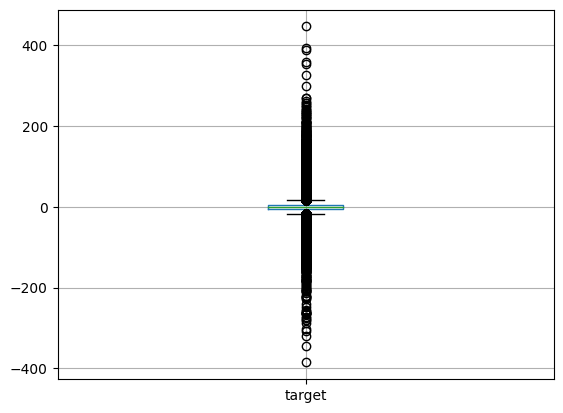

In [13]:
df_data.boxplot(column=['target'])
plt.show()

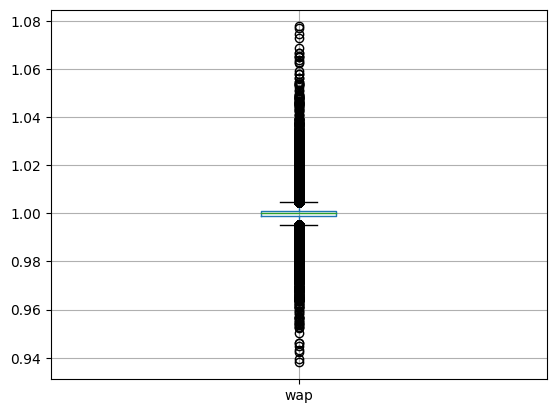

In [14]:
df_data.boxplot(column=['wap'])
plt.show()

These visualizations would provide insights into the distribution, range, and potential outliers within these critical metrics.

The target boxplot would reveal the spread of the dependent variable that the models aim to predict.

The WAP (Weighted Average Price) boxplot would highlight the central tendency and variation in prices, a key factor in financial analyses.

### 4. Data Visualization

#### Visualize the Correlation Matrix

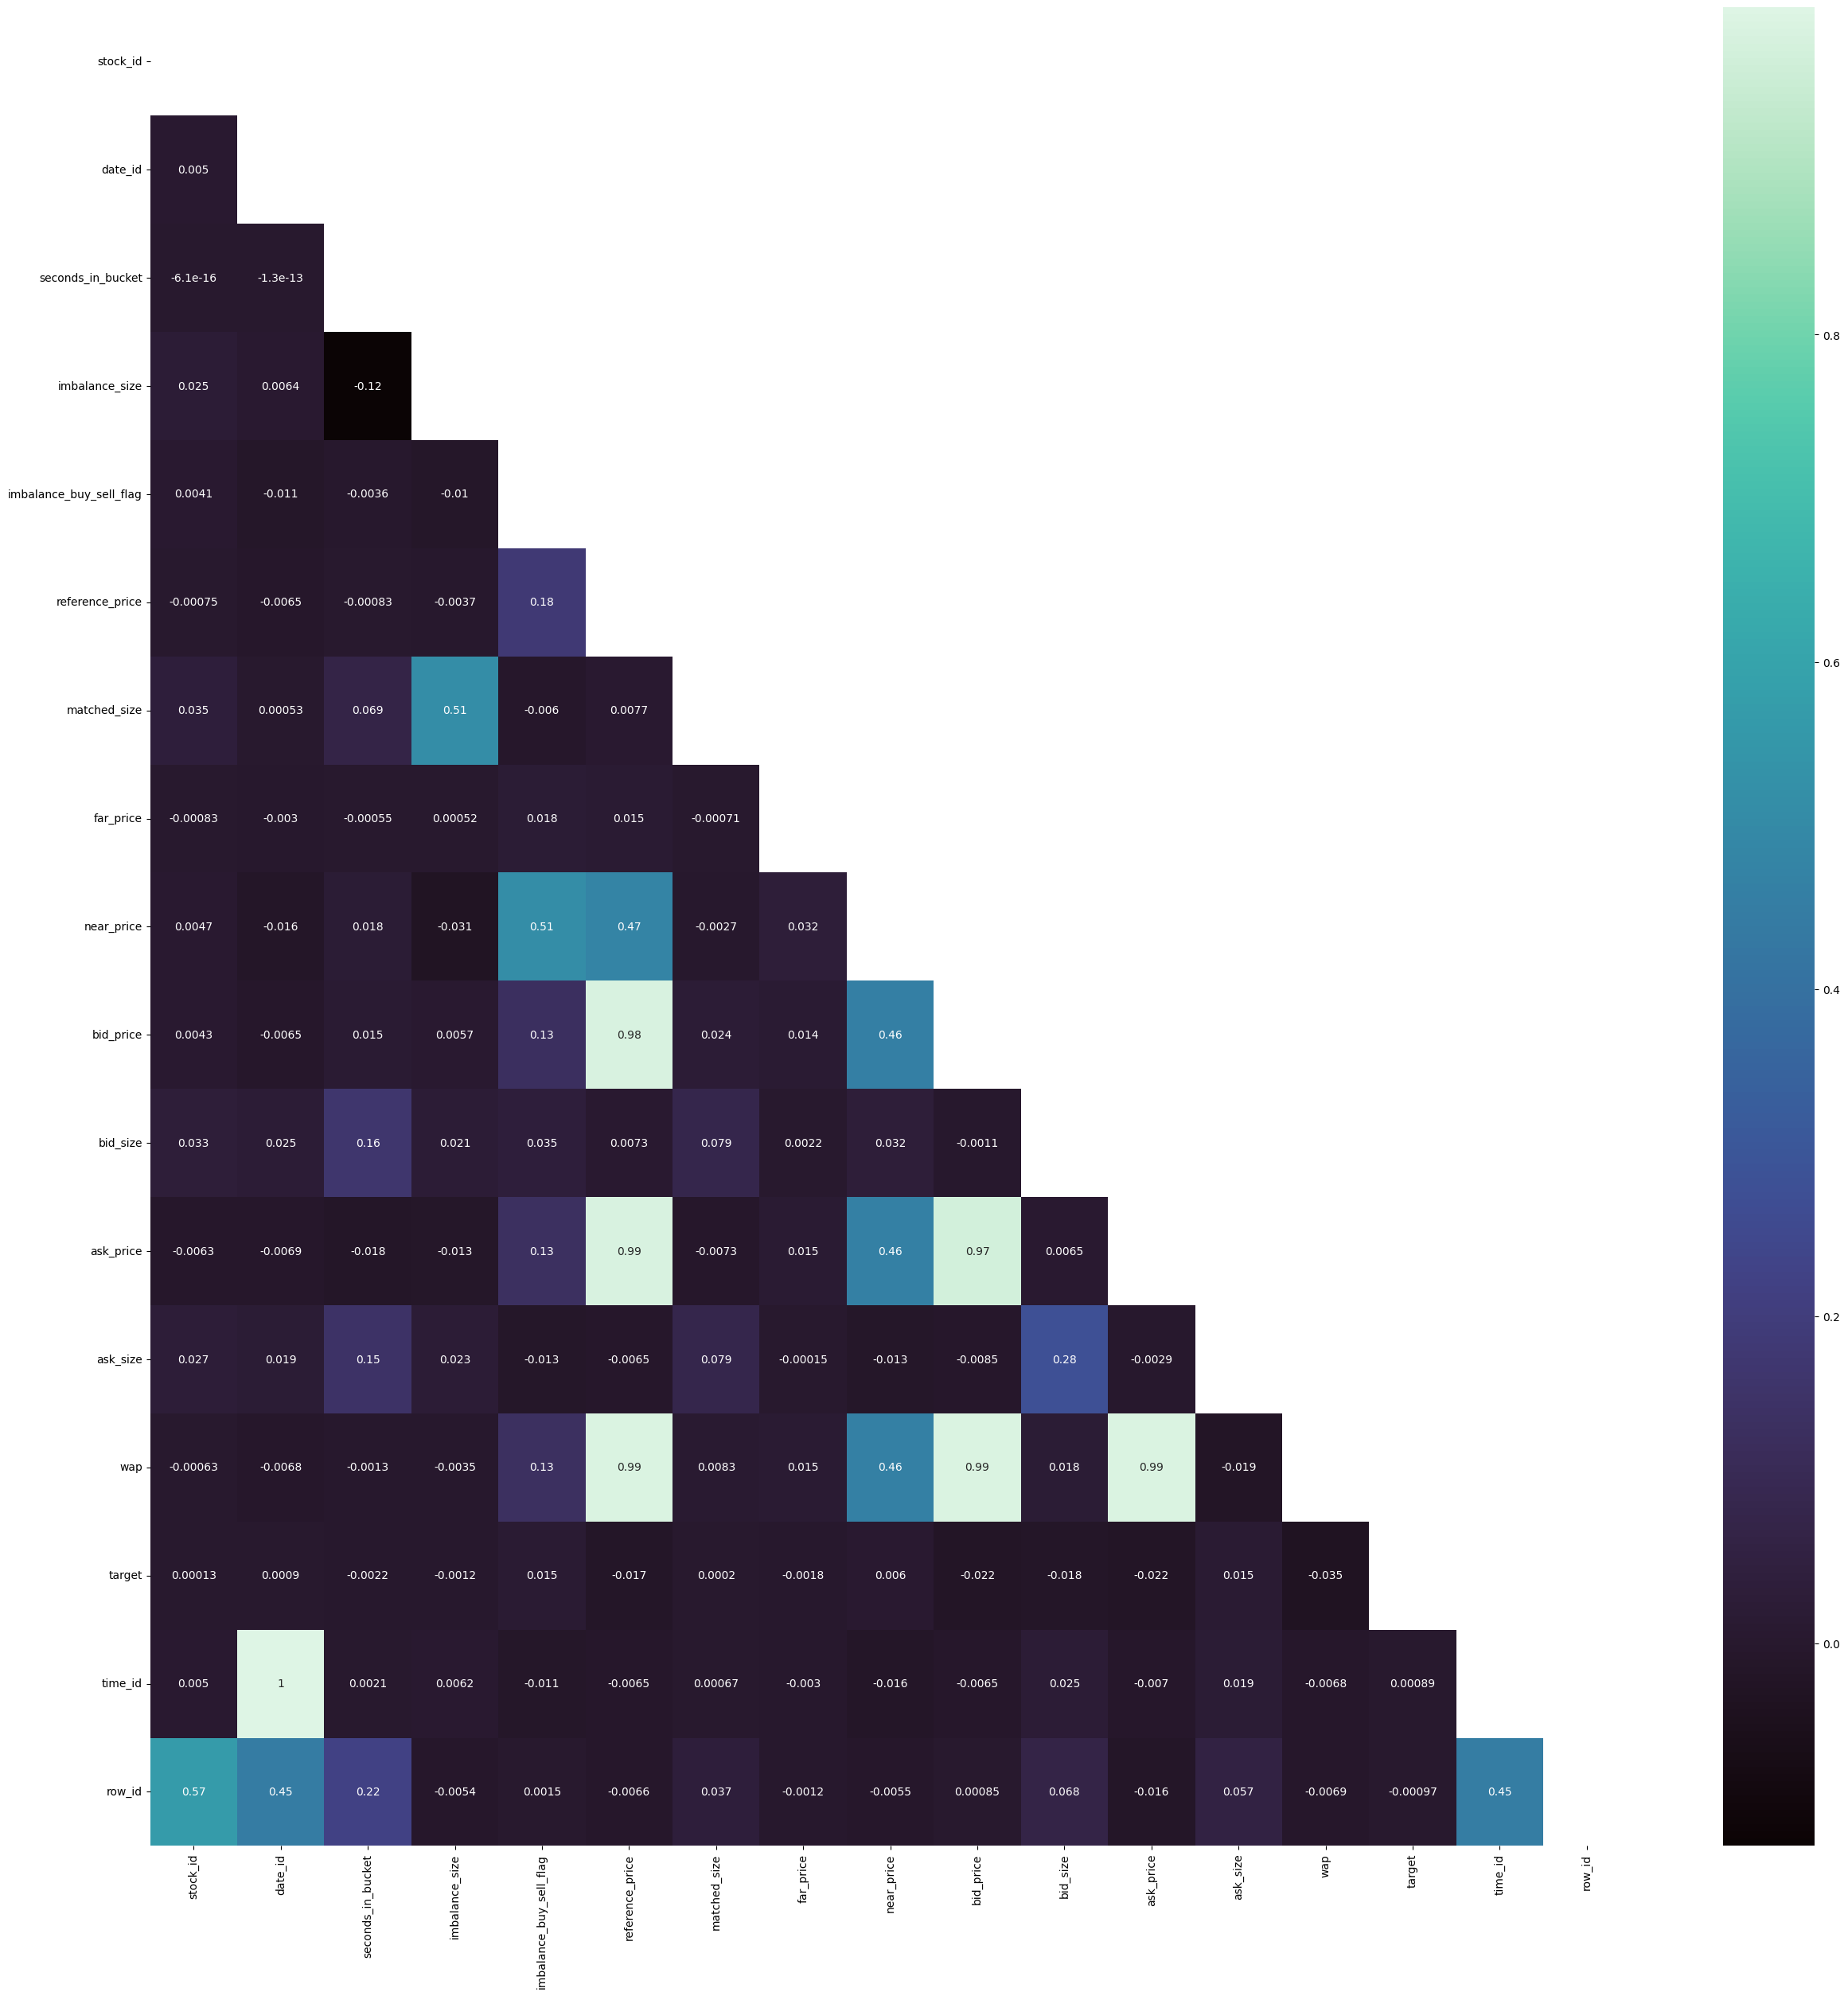

In [15]:
plt.figure(figsize=(30,30))
corr=df_data.corr()
sns.heatmap(corr,annot=True,cmap='mako',mask=np.triu(corr))
plt.show()

A correlation heatmap is an effective tool for visualizing the relationships between different variables in the dataset.
This help in identifying which features are most strongly related to the target, guiding feature selection for modeling.

It seems that wap has the strongest correlation with the target in this heatmap.

#### Visualization of 'Target' Prediction Values

In [16]:
df_data['target'].describe()

count    5.237760e+06
mean    -4.758886e-02
std      9.452816e+00
min     -3.852898e+02
25%     -4.559755e+00
50%     -6.020069e-02
75%      4.409552e+00
max      4.460704e+02
Name: target, dtype: float64

#### Exploring the Distribution of 'target'

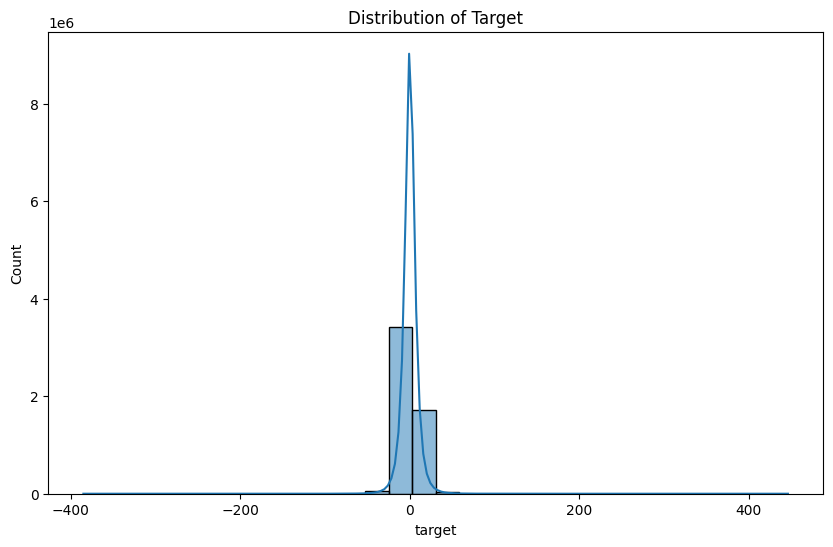

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_data['target'], bins=30, kde=True)
plt.title('Distribution of Target')
plt.show()

#### Changes in the 'Target' with Rolling Time

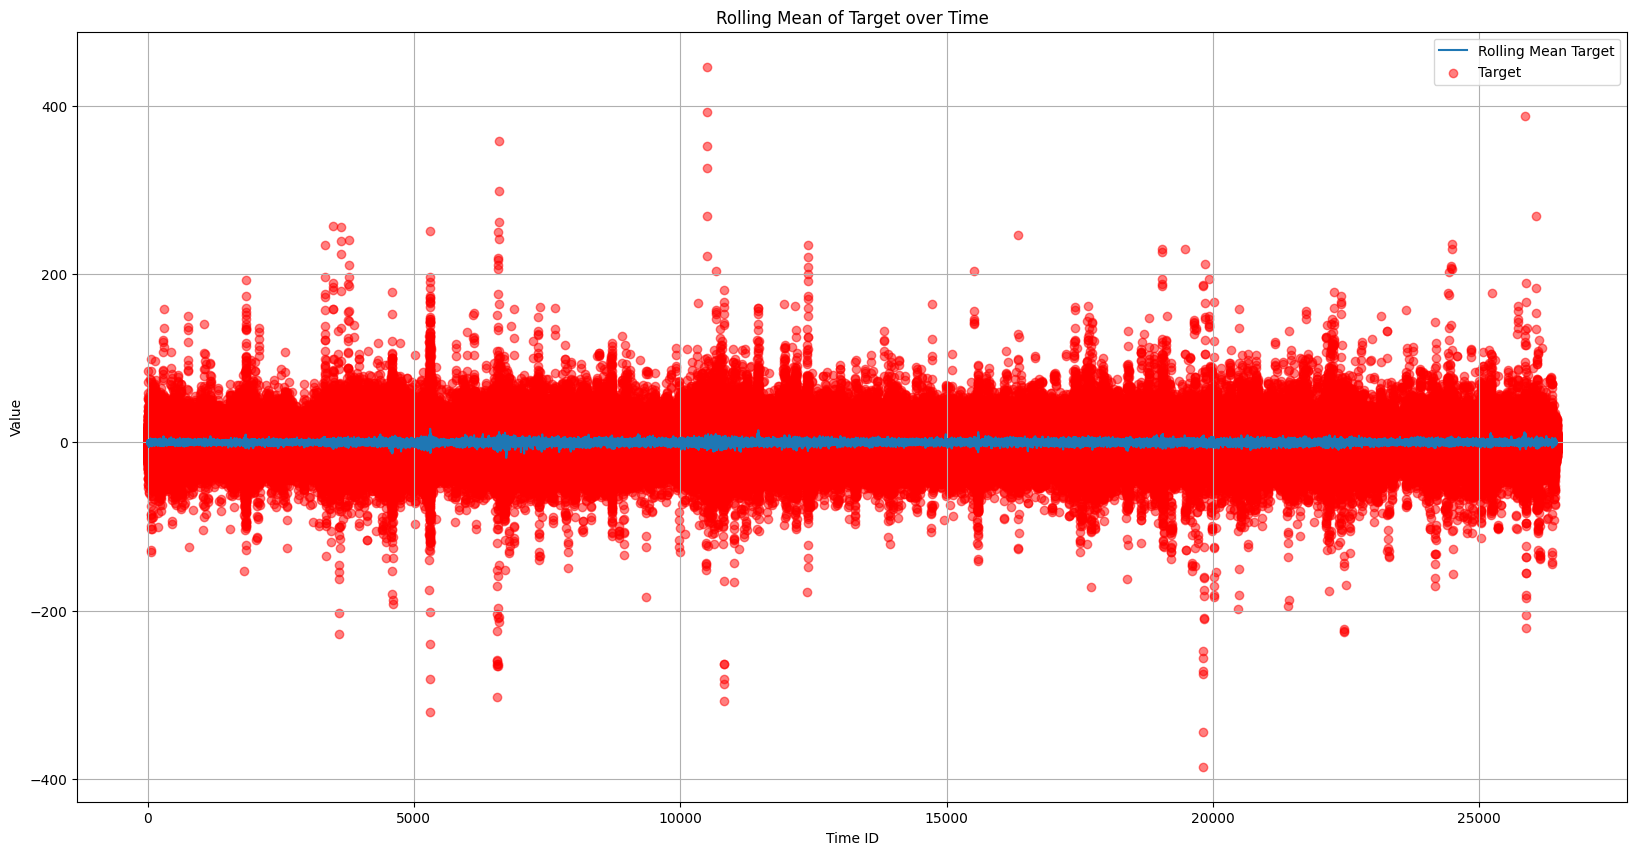

In [17]:
# Calculate rolling mean of the 'Target' variable over a window of, say, 50 time points
rolling_target_mean = df_data['target'].rolling(window=50).mean()

# Plot the rolling mean
plt.figure(figsize=(20, 10))
plt.plot(df_data['time_id'], rolling_target_mean, label='Rolling Mean Target')
plt.scatter(df_data['time_id'], df_data['target'], color='red', label='Target', alpha=0.5)
plt.xlabel('Time ID')
plt.ylabel('Value')
plt.title('Rolling Mean of Target over Time')
plt.legend()
plt.grid()
plt.show()


##### Temporal Trends

Analysis included examining rolling means and using scatter plots to capture the time-based trends in the target variable.

These plots are essential in financial data analysis to understand how the target variable evolves over time and to identify any patterns or anomalies.

#### The stability of each stock based on the target variable

     stock_id  target_stability
112       112          4.827514
45         45          4.848838
130       130          4.997084
160       160          5.193113
55         55          5.219140
..        ...               ...
174       174         17.778500
92         92         17.907262
86         86         17.981217
31         31         20.202133
82         82         22.004510

[200 rows x 2 columns]


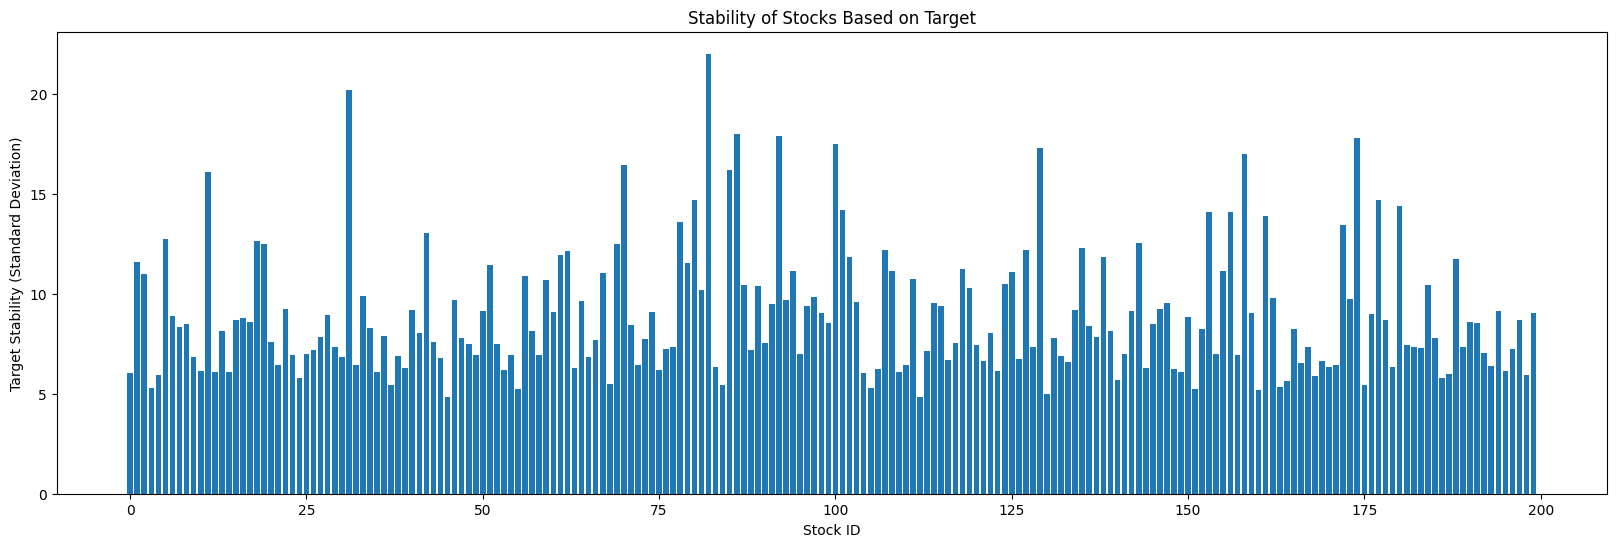

In [19]:
stability = df_data.groupby('stock_id')['target'].std().reset_index()
stability.columns = ['stock_id', 'target_stability']

stability = stability.sort_values(by='target_stability')
print(stability)


plt.figure(figsize=(20, 6))
plt.bar(stability['stock_id'], stability['target_stability'])
plt.xlabel('Stock ID')
plt.ylabel('Target Stability (Standard Deviation)')
plt.title('Stability of Stocks Based on Target')
plt.show()

##### Stock Stability Analysis

The variability of the target variable across different stocks was visualized to assess the volatility associated with each stock.

This analysis is crucial for understanding which stocks are more stable and which exhibit higher fluctuations, potentially impacting predictive modeling.

#### An overview of price-related data and the target variable for a specific stock (Stock ID 0)

In [20]:
stock_id_0_df = df_data[df_data['stock_id'] == 0].head(700) 

In [21]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['ask_price'], 
            name = 'ask price',
            line = dict(color = 'blue')))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['bid_price'], 
            name = 'bid price',
            line = dict(color = 'green')))


fig.update_layout(title = "Overview for Ask Price and Bid Price",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1000,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20))

In [22]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['target'], 
            name = 'Target variable',
            line = dict(color = 'red'),
            yaxis = "y2"))

fig.add_trace(
    go.Scatter(x = stock_id_0_df['time_id'], 
            y = stock_id_0_df['wap'], 
            name = 'WAP',
            line = dict(color = 'black')))

fig.update_layout(title = "Overview for WAP and Target Variable",
                title_font = dict(size = 15),
                showlegend = True,
                width = 1000,
                height = 400,
                margin = dict(l = 40, r = 40, t = 40, b = 20),
                yaxis2 = dict(title = "Target Variable", overlaying = "y", side = "right"),)

# 02 Feature Engineering

##### Feature Engineering - Detailed Steps

##### 1.Creation of Financial Indicators

New features like log returns, realized volatility, total volume, and price spreads were engineered.
These features are standard in financial analysis and are crucial for capturing market dynamics and stock behavior.

##### 2.Rolling Features

Rolling statistical measures (mean and standard deviation) were calculated for selected features to capture temporal trends and volatility in the market.
Rolling features help in understanding the short-term fluctuations and longer-term trends in the data.

##### 3.Aggregation of Features

Features were aggregated (e.g., mean, sum) for each combination of stock and time ID.
Aggregation helps in reducing the granularity of the data and focusing on broader trends and patterns relevant to each stock and time period.

##### Here's a summary of the newly constructed features and the rationale behind them:

- Log Return: Calculated as the logarithmic difference in the Weighted Average Price (WAP). This feature captures the percentage change in price over time, a fundamental metric in finance for assessing stock performance.

- Realized Volatility: Derived from the log returns, it represents the sum of squared log returns. Realized volatility is a measure of the amount of variation or dispersion in a stock's price, indicating the degree of risk or uncertainty.

- Total Volume: The sum of ask size and bid size. This feature gives an insight into the trading activity level, as higher volumes often signal stronger interest in a stock.

- Volume Imbalance: Calculated as the difference between ask size and bid size. It provides an indication of supply-demand dynamics, where a significant imbalance can suggest directional pressure on the stock price.

- Imbalance Ratio: The ratio of imbalance size to matched size. This feature helps to understand the proportion of total orders that are imbalanced, highlighting potential price pressure scenarios.

- Ask-Bid Spread: Represents the difference between ask price and bid price. A wider spread can indicate lower liquidity or higher transaction costs, impacting trading strategies.

- Mid Price: The average of ask price and bid price. This is a commonly used metric in finance that provides a more stable reference point than either the bid or ask price alone.

- Imbalance Price Ratio: The ratio of bid price to ask price. It gives a sense of the relative positioning of buy and sell orders.

- Price Spread: Calculated as the difference between ask and bid prices, normalized by the mid-price. This feature helps to understand the relative width of the spread in percentage terms.

- Order Size Imbalance: The difference between bid size and ask size, normalized. It reflects the relative strength of buying versus selling pressure.

- Matching Imbalance: The difference between imbalance size and matched size, normalized. This feature highlights the extent to which orders are not matched in the market.

- Rolling Means and Standard Deviations: Applied to features like realized volatility, total volume, and WAP. These rolling statistics capture trends and fluctuations over a specified window, providing a dynamic view of market conditions.

##### Reason for Feature Construction:

Enhance Predictive Accuracy: By incorporating these features, the model can capture various market aspects, potentially leading to more accurate predictions.

Capture Market Dynamics: These features collectively provide a comprehensive view of market behavior, including price movements, volatility, liquidity, and order flow.
Risk Assessment: Features like volatility and spread are crucial for risk management in trading and investment.

Adapt to Financial Theories: These features align with financial theories that emphasize the importance of price trends, volatility, liquidity, and order book dynamics in determining stock prices.

Overall, these newly constructed features are tailored to encapsulate essential aspects of financial market behavior, thereby aiming to improve the model's ability to make informed predictions about stock price movements relative to a synthetic index.

In [7]:
def log_return(wap):
    return np.log(wap).diff()

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def fill_missing_values(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col].fillna(df[col].mean(), inplace=True)
    return df

#### Adding basic finacial feature

In [8]:
def preprocess_data(df):
    df_copy = df.copy()

    df_copy['log_return'] = log_return(df_copy['wap'])
    df_copy['realized_volatility'] = realized_volatility(df_copy['log_return'])

    df_copy['total_volume'] = df_copy['ask_size'] + df_copy['bid_size']
    df_copy['volume_imbalance'] = df_copy['ask_size'] - df_copy['bid_size']
    df_copy['imbalance_ratio'] = df_copy['imbalance_size'] / (df_copy['matched_size'] + 1.0e-8)
    df_copy['ask_bid_spread'] = df_copy['ask_price'] - df_copy['bid_price']
    df_copy['askbid'] = df_copy["bid_size"] * df_copy["ask_size"]
    df_copy['mid_price'] = (df_copy['ask_price'] + df_copy['bid_price']) / 2
    df_copy["imbalance_price"] = df_copy["bid_price"] / df_copy["ask_price"]
    df_copy['price_spread'] = (df_copy['ask_price'] - df_copy['bid_price']) / ((df_copy['ask_price'] + df_copy['bid_price']) / 2)
    df_copy['ordersize_imbalance'] = (df_copy['bid_size'] - df_copy['ask_size']) / ((df_copy['bid_size'] + df_copy['ask_size']) + 1.0e-8)
    df_copy['matching_imbalance'] = (df_copy['imbalance_size'] - df_copy['matched_size']) / ((df_copy['imbalance_size'] + df_copy['matched_size']) + 1.0e-8)

    return df_copy

#### Adding Rolling Features

In [9]:
def add_rolling_features(df):
    df_copy = df.copy()

    rolling_columns = ['realized_volatility', 'total_volume', 'volume_imbalance', 'price_spread', 'wap']
    for col in rolling_columns:
        df_copy[f'rolling_mean_{col}'] = df_copy[col].rolling(window=5).mean()
        df_copy[f'rolling_std_{col}'] = df_copy[col].rolling(window=5).std()
    return df_copy

#### Feature Engineering on Financial Data

In [10]:
def aggregate_features(df):
    df_copy = df.copy()

    agg_features = {
        'realized_volatility': [np.mean],
        'total_volume': [np.sum, np.mean],
        'volume_imbalance': [np.mean],
        'imbalance_ratio': [np.mean],
        'ask_bid_spread': [np.mean],
        'askbid': [np.mean],
        'mid_price': [np.mean],
        "imbalance_price": [np.mean],
        'ordersize_imbalance': [np.mean],
        'rolling_mean_wap': [np.mean],
        'matching_imbalance': [np.mean],
    }

    df_agg = df_copy.groupby(['stock_id', 'time_id']).agg(agg_features)
    df_agg.columns = ['_'.join(col) for col in df_agg.columns]

    return df_agg.reset_index()

In [11]:
from sklearn.preprocessing import StandardScaler

def scale_features(df, exclude_columns=['stock_id', 'time_id']):
    df_copy = df.copy()
    scaler = StandardScaler()
    features_to_scale = df_copy.columns.difference(exclude_columns)
    df_scaled = df_copy.copy()
    df_scaled[features_to_scale] = scaler.fit_transform(df_copy[features_to_scale])

    return df_scaled

In [13]:
def process_stock_data(df_data):
    df_processed = preprocess_data(df_data)
    df_with_rolling = add_rolling_features(df_processed)
    df_aggregated = aggregate_features(df_with_rolling)
    df_final = scale_features(df_aggregated)

    return df_final

In [14]:
processed_data = process_stock_data(df_data)

merged_df = df_data.merge(processed_data, on=['stock_id', 'time_id'], how='left')

merged_df.interpolate(method='linear', inplace=True)

print(merged_df.head())

/tmp/ipykernel_13/705844063.py:18: FutureWarning: The provided callable <function mean at 0x7e8f45b84040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_agg = df_copy.groupby(['stock_id', 'time_id']).agg(agg_features)
/tmp/ipykernel_13/705844063.py:18: FutureWarning: The provided callable <function sum at 0x7e8f45b6f0a0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_agg = df_copy.groupby(['stock_id', 'time_id']).agg(agg_features)
/tmp/ipykernel_13/3576238354.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df.interpolate(method='linear', inplace=True)


   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        NaN   
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  ...  total_volume_mean  volume_imbalance_mean  \
0         NaN   0.999812  ...          -0.188002              -0.370988   
1         NaN   0.999896  ...          -0.422994              

## 03 Data Preprocess

#### Check the Missing Value

In [15]:
missing_values = merged_df.isna()
missing_counts = missing_values.sum()
print("Columns with missing values:")
print(missing_counts[missing_counts > 0])

Columns with missing values:
far_price                5730
near_price               5730
rolling_mean_wap_mean       4
dtype: int64


#### Drop the Missing Value

In [16]:
merged_df = merged_df.dropna(subset=['rolling_mean_wap_mean','far_price', 'near_price'])

#### Correlations of numerical values

In [14]:
merged_df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,total_volume_mean,volume_imbalance_mean,imbalance_ratio_mean,ask_bid_spread_mean,askbid_mean,mid_price_mean,imbalance_price_mean,ordersize_imbalance_mean,rolling_mean_wap_mean,matching_imbalance_mean
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,...,-0.362668,-0.033938,-0.398740,-0.554243,-0.085542,0.055516,0.554944,0.179230,-0.173404,-0.827581
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,...,-0.311946,-0.295335,-0.282767,0.387198,-0.088497,-0.027895,-0.388195,1.594770,-0.003474,-0.417020
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,...,-0.138651,0.268012,-0.398740,2.508440,-0.074705,0.016122,-2.510820,-0.868194,0.061651,-0.827581
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,...,-0.217450,0.072689,-0.288594,-0.554243,-0.076863,-0.024478,0.554871,-0.310154,0.068070,-0.436282
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,...,-0.458216,-0.093624,-0.261331,-0.329600,-0.089167,-0.589063,0.328960,1.223978,-0.170603,-0.347307


In [15]:
print(merged_df.dtypes)

stock_id                      int64
date_id                       int64
seconds_in_bucket             int64
imbalance_size              float64
imbalance_buy_sell_flag       int64
reference_price             float64
matched_size                float64
far_price                   float64
near_price                  float64
bid_price                   float64
bid_size                    float64
ask_price                   float64
ask_size                    float64
wap                         float64
target                      float64
time_id                       int64
row_id                       object
realized_volatility_mean    float64
total_volume_sum            float64
total_volume_mean           float64
volume_imbalance_mean       float64
imbalance_ratio_mean        float64
ask_bid_spread_mean         float64
askbid_mean                 float64
mid_price_mean              float64
imbalance_price_mean        float64
ordersize_imbalance_mean    float64
rolling_mean_wap_mean       

In [16]:
merged_df.corr()['target'].sort_values()

ordersize_imbalance_mean   -0.114558
wap                        -0.035177
bid_price                  -0.022348
mid_price_mean             -0.022173
ask_price                  -0.021699
bid_size                   -0.017993
reference_price            -0.017425
rolling_mean_wap_mean      -0.009821
imbalance_price_mean       -0.002518
seconds_in_bucket          -0.002255
imbalance_size             -0.001255
askbid_mean                -0.001173
far_price                  -0.001141
row_id                     -0.001045
near_price                 -0.000881
total_volume_mean          -0.000385
total_volume_sum           -0.000385
stock_id                    0.000163
matched_size                0.000164
time_id                     0.000732
date_id                     0.000736
ask_bid_spread_mean         0.002383
matching_imbalance_mean     0.004699
imbalance_ratio_mean        0.005123
ask_size                    0.014925
imbalance_buy_sell_flag     0.015077
volume_imbalance_mean       0.027077
t

# 04 Split data into features and target

## TEST 1 - Random Sampling


The data is split into features and target, followed by further splitting into training and test sets. The steps and their rationale are as follows:

- Feature-Target Separation:
x_cols is defined to include all columns except 'row_id', 'time_id', 'date_id', 'row_id', and 'target'. These columns are chosen as features (X) because they contain the independent variables that are expected to influence the target variable.
y_cols is set to ["target"], isolating the dependent variable (y) that the model aims to predict.

- Sampling a Fraction of Data:
sample_fraction = 0.1 implies that only 10% of the data is used for the analysis.
train_test_split with test_size=1-sample_fraction is used to randomly select this 10% of the data. This step reduces the dataset size, making the model training more computationally manageable, especially important for large datasets.

- Splitting into Training and Test Sets:
The 10% sampled data is further divided into training and test sets using train_test_split(X, y, test_size=0.25, random_state=42).
test_size=0.25 means that 25% of the sampled data is reserved for testing the model, and the remaining 75% is used for training.
random_state=42 ensures reproducibility of the results by setting a seed for the random number generator used in splitting the data.

- Assessing Data Split Sizes:
Printing the shapes of X_train and X_test helps verify the size of the datasets used for training and testing, ensuring that the split was executed as intended.
Overall, these steps are crucial for preparing the data for model training and evaluation, ensuring that there is enough data to learn from while also setting aside a portion of the data to assess model performance.

In [17]:
from sklearn.model_selection import train_test_split

x_cols = [c for c in merged_df.columns if c not in ['row_id', 'time_id','date_id', 'row_id','target']]
y_cols = ["target"]

X = merged_df[x_cols]
y = merged_df[y_cols]

In [18]:
sample_fraction = 0.1
X, _, y, _ = train_test_split(X, y, test_size=1-sample_fraction, random_state=42)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (392402, 25)
Test set size: (130801, 25)


## TEST 2 -  Apply the Sliding Window Technique（window_size = 5）

When sampling time series data for models like LSTM, it's crucial to maintain the chronological order of data. Instead of random sampling, a time series-friendly approach involves selecting continuous segments of the data. This method ensures that the temporal structure of the data is preserved, allowing the model to learn from sequences as they naturally occur. For instance, if the dataset spans several years, one could sample contiguous months or weeks from each year, ensuring that the sequence's flow is maintained.

In [18]:
is_sorted = merged_df['time_id'].is_monotonic_increasing
print("DataFrame is sorted by time:", is_sorted)

DataFrame is sorted by time: True


In [19]:
from torch.utils.data import DataLoader, TensorDataset

# Function to create a sliding window dataset from the data
def create_sliding_window(data, window_size=5):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :-1])  # All columns except the target
        y.append(data[i + window_size, -1])  # Just the target variable
    return np.array(X), np.array(y)

columns_to_use = [col for col in merged_df.columns if col != 'row_id']
data = merged_df[columns_to_use].to_numpy(dtype=np.float32)  # Convert to numpy array and ensure type is float32

# Apply the sliding window function to the data
window_size = 5 
X, y = create_sliding_window(data, window_size)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Check the shapes
print(X_tensor.shape, y_tensor.shape)


torch.Size([5232025, 5, 27]) torch.Size([5232025])


In [21]:
# Define the split ratio
split_ratio = 0.8  # 80% for training, 20% for testing

# Calculate the index for splitting
split_index = int(X_tensor.shape[0] * split_ratio)

# Split the tensors into training and testing datasets
X_train = X_tensor[:split_index]
y_train = y_tensor[:split_index]
X_test = X_tensor[split_index:]
y_test = y_tensor[split_index:]

# Check the shapes of the split datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# Creating TensorDataset for DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Example: DataLoader creation for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)  # Shuffling is not needed for time series
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Training set shape: torch.Size([4185620, 5, 27]), torch.Size([4185620])
Testing set shape: torch.Size([1046405, 5, 27]), torch.Size([1046405])


# 05 Building Model 

Choosing these four models (LSTM, Random Forest, LightGBM, and an ensemble of LightGBM and XGBoost) for predicting stock price movements relative to a synthetic index is grounded in several strategic considerations:

#### 1. LSTM (Long Short-Term Memory) Model:

Time-Series Data Handling: Financial markets are inherently time-series in nature. LSTM models excel in capturing sequential dependencies and long-term relationships in time-series data, crucial for understanding stock price movements.
Handling Volatility and Trends: LSTM can be effective in modeling the volatile and trend-based nature of stock prices, offering insights into future movements based on historical patterns.

#### 2. Random Forest Model:

Baseline Model: Random Forest serves as a robust and straightforward baseline model. Its performance provides a benchmark to compare more complex models.
Feature Importance Insights: It helps in understanding the impact of various features on stock price movements, as Random Forest can provide clear insights into feature importance.

#### 3. LightGBM (Light Gradient Boosting Machine) Model:

Handling Large and Complex Datasets: LightGBM is known for its efficiency with large datasets and its ability to handle complex feature interactions, making it suitable for the multifaceted nature of financial data.
Speed and Accuracy: It offers a balance between computational efficiency and predictive accuracy, crucial for timely financial predictions.

#### 4. Ensemble of LightGBM and XGBoost:

Combining Strengths: The idea behind using an ensemble is to combine the strengths of both LightGBM and XGBoost to potentially achieve better performance than any single model.
Diverse Perspectives: Each model may capture different aspects or nuances of the data, and an ensemble aims to leverage these diverse perspectives for a more robust prediction.


## 1. LSTM Model

### TEST 1 - Random Sample

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [37]:
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
  
    X_train = np.nan_to_num(X_train)

if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
    X_test = np.nan_to_num(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

num_epochs = 10
for epoch in range(num_epochs):
    for data, target in train_loader:
      
        pass

for data, target in test_loader:

    pass


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
       
        return predictions.squeeze()  

input_size = 25 
hidden_layer_size = 50
output_size = 1 
num_layers = 3
model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
epochs = 3  
for epoch in range(epochs):

    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                         torch.zeros(1, 1, model.hidden_layer_size))

    for sequence, target in train_loader:  
        sequence = sequence.unsqueeze(1)

        optimizer.zero_grad()
        prediction = model(sequence)
        loss = loss_function(prediction.squeeze(), target.view(-1)) 
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch} Loss: {loss.item()}')

model.eval()  
total_mae = 0.0
total_samples = 0

with torch.no_grad():
    for sequence, target in test_loader:  
        sequence = sequence.unsqueeze(1)
        prediction = model(sequence)
        mae_loss = loss_function(prediction.squeeze(), target.view(-1))  # 同上
        total_mae += mae_loss.item() * len(target)
        total_samples += len(target)

average_mae = total_mae / total_samples
print(f'Average MAE: {average_mae}')


Epoch 0 Loss: 5.59230899810791
Epoch 1 Loss: 9.230490684509277
Epoch 2 Loss: 3.7952091693878174
Average MAE: 6.304350932872377


## 2.Random Forest Model

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error

In [58]:
rf = RandomForestRegressor(random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_


In [59]:
sorted_feature_indices = feature_importances.argsort()[::-1]

k = 6
selected_feature_indices = sorted_feature_indices[:k]

X_train_selected = X_train.iloc[:, selected_feature_indices]
X_test_selected = X_test.iloc[:, selected_feature_indices]

rf_selected = RandomForestRegressor(random_state=42)

param_dist = {
    
}

random_search = RandomizedSearchCV(
    estimator=rf_selected, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_selected, y_train)

print("Best parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test_selected)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[CV] END .................................................... total time=10.1min
[CV] END .................................................... total time=10.3min
[CV] END .................................................... total time=10.4min
Best parameters: {}
MAE: 6.438239188210283


Top 1 Feature: matched_size, Importance: 0.07819529121319696
Top 2 Feature: rolling_mean_wap_mean, Importance: 0.07220584680820043
Top 3 Feature: ordersize_imbalance_mean, Importance: 0.06484161576145034
Top 4 Feature: near_price, Importance: 0.05798738953281407
Top 5 Feature: far_price, Importance: 0.05679157341052535
Top 6 Feature: imbalance_price_mean, Importance: 0.053986438335949564


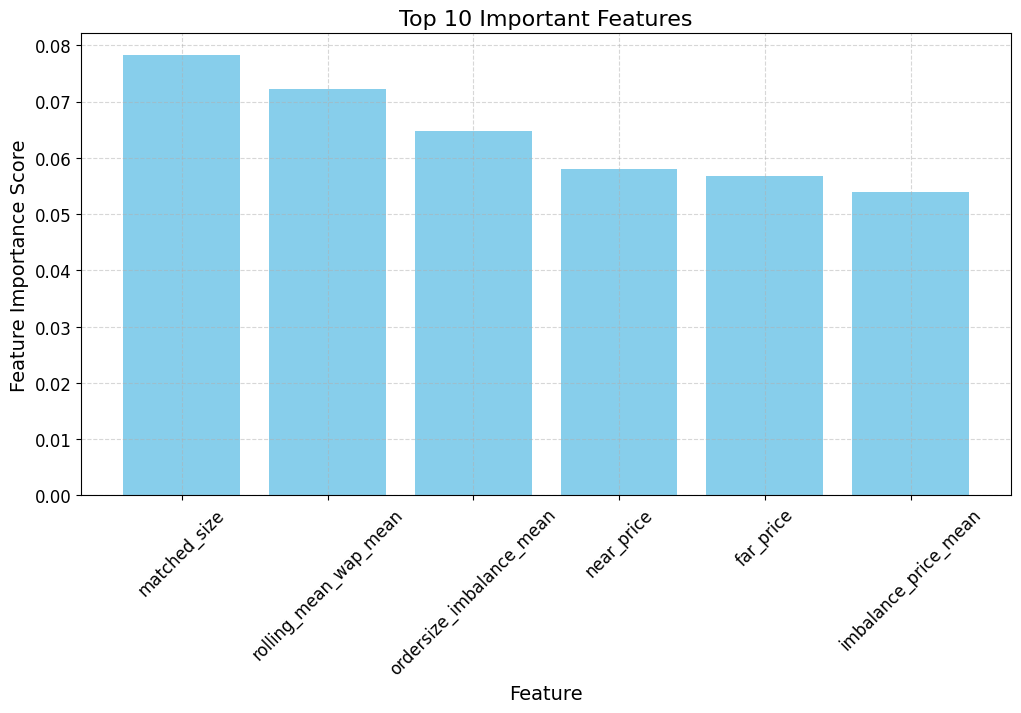

In [60]:
selected_feature_names = [x_cols[i] for i in selected_feature_indices]

for i, feature_name in enumerate(selected_feature_names):
    print(f"Top {i + 1} Feature: {feature_name}, Importance: {feature_importances[selected_feature_indices[i]]}")

plt.figure(figsize=(12, 6))
plt.bar(range(k), feature_importances[selected_feature_indices], color='skyblue')
plt.xticks(range(k), selected_feature_names, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Feature Importance Score', fontsize=14)
plt.title('Top 6 Important Features', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


## 3.LightGBM Model

In [2]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 392402, number of used features: 24
[LightGBM] [Info] Start training from score -0.027667
MAE: 6.26861212476161


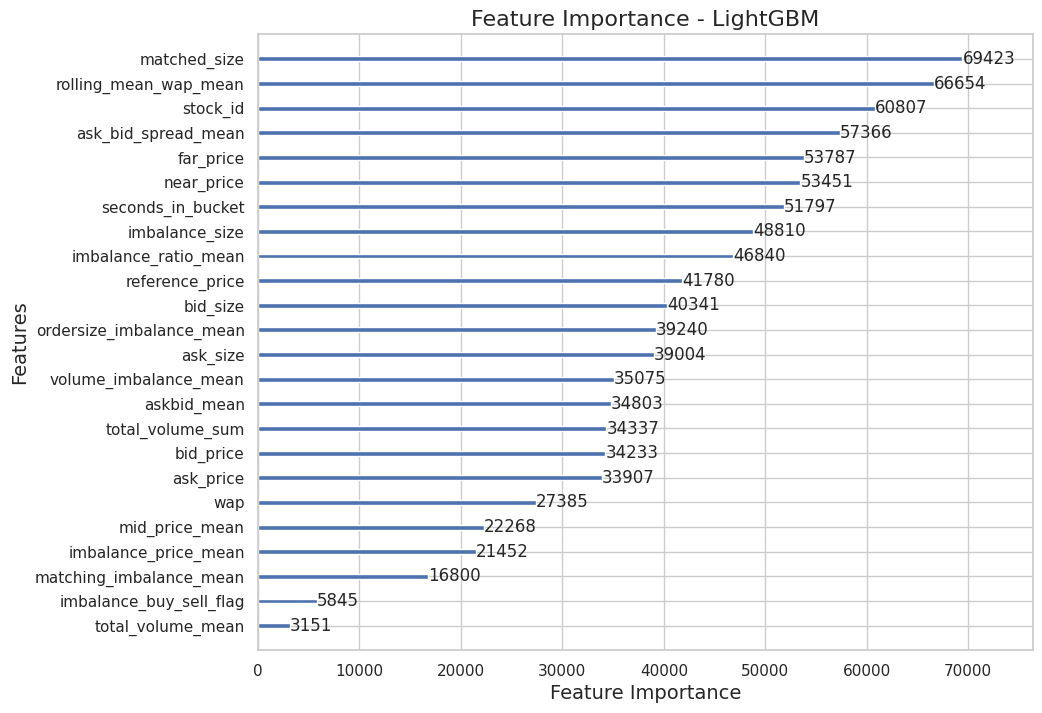

In [82]:
lgb_params = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'learning_rate': 0.02,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
  }
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(lgb_params, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=False)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

ax = lgb.plot_importance(lgb_model, max_num_features=30, importance_type='split', figsize=(10, 8))
plt.title("Feature Importance - LightGBM", fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.show()

In [84]:
importances = lgb_model.feature_importance(importance_type='split')
feature_names = X_train.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

top_features = feature_importances['feature'].iloc[:6].tolist()

print(top_features)

['matched_size', 'rolling_mean_wap_mean', 'stock_id', 'ask_bid_spread_mean', 'far_price', 'near_price']


### Important Features

The features identified - matched size, rolling mean WAP, stock ID, order size imbalance mean, near and far prices, imbalance price mean, and ask-bid spread mean - are crucial in predicting the target in financial models due to their direct correlation with market behavior and dynamics. Here's why each of them holds significant importance:

#### Matched Size (matched_size):
Market Activity Indicator: Represents the volume of stocks traded within a specific timeframe. Higher volumes often signal strong market interest, leading to more pronounced price movements, especially around major events or news.
Liquidity and Volatility: High trade volumes can indicate liquidity, making it easier to execute large orders without significantly impacting the price.

#### Rolling Mean of Weighted Average Price (rolling_mean_wap_mean):
Trend Analysis: Offers insights into stock price trends and momentum. A steadily increasing or decreasing WAP suggests bullish or bearish sentiment, respectively.
Market Sentiment Indicator: Helps in understanding the general market sentiment and the stock's direction, assisting in forecasting future price changes.

#### Stock ID (stock_id):
Stock-Specific Characteristics: Allows the model to incorporate unique aspects of individual stocks like sector, market cap, and historical performance.
Diversified Analysis: Different stocks react differently to market events; this feature helps capture such nuanced behaviors.

#### Order Size Imbalance Mean (ordersize_imbalance_mean):
Supply-Demand Dynamics: Indicates the difference between buy and sell order sizes. A significant imbalance can signal changes in market sentiment, influencing stock prices.
Predictive of Market Movements: Large imbalances can forewarn of impending price changes.

#### Near and Far Prices (near_price, far_price):
Liquidity Indicators: Show different levels of liquidity in the market. The near price suggests immediate liquidity, while the far price indicates future liquidity prospects.
Market Depth Insight: Useful in assessing market depth and how it might affect price volatility.

#### Imbalance Price Mean (imbalance_price_mean):
Market Stability Indicator: Reflects the average difference or ratio between bid and ask prices, signaling liquidity and market stability.
Precursor to Market Shifts: Changes in this mean can indicate upcoming price movements due to shifting supply and demand.

#### Ask-Bid Spread Mean (ask_bid_spread_mean):
Liquidity and Cost Insight: Averages the difference between asking and bidding prices, indicating market liquidity and transaction costs.
Sentiment and Market Dynamics: Varying spreads can reflect changing market sentiment and conditions, crucial for predicting price movements.

In summary, these features collectively provide a comprehensive view of market dynamics, including trading activity, liquidity, sentiment, and individual stock characteristics, which are pivotal in forecasting stock market movements and understanding the underlying mechanics of price formation.



## 4. LightGBM Model + XGBoost Model

In [88]:
lgb_params = {
    "num_leaves": [900],  
    "objective": ["regression"], 
    "metric": ["mae"], 
    "boosting_type": ["gbdt"],
    'learning_rate': [0.02],
    'lambda_l1': [1],
    'lambda_l2': [1],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.9]
}

xgb_params = {
    'learning_rate': [0.05],
    'max_depth': [7],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'alpha': [1.0]
}

In [89]:
kf = KFold(n_splits=3, random_state=42, shuffle=True)
mae_scores = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # LightGBM Model Training
    lgb_model = lgb.LGBMRegressor()
    grid_search_lgb = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='neg_mean_absolute_error')
    grid_search_lgb.fit(X_train_fold, y_train_fold)
    lgb_best = grid_search_lgb.best_estimator_

    # XGBoost Model Training
    xgb_model = xgb.XGBRegressor()
    grid_search_xgb = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_absolute_error')
    grid_search_xgb.fit(X_train_fold, y_train_fold)
    xgb_best = grid_search_xgb.best_estimator_


    lgb_pred = lgb_best.predict(X_val_fold)
    xgb_pred = xgb_best.predict(X_val_fold)
    ensemble_pred = (lgb_pred + xgb_pred) / 2
    mae_score = mean_absolute_error(y_val_fold, ensemble_pred)
    mae_scores.append(mae_score)

print(f"Average MAE: {np.mean(mae_scores)}")

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] 

# 06 Model First Comparison

Due to the vast size of the original dataset, a 10% sample was extracted, resulting in a subset of 392,402 data points with 25 features. This sampling approach allows for a more manageable dataset size while still capturing the essential characteristics of the larger dataset. On this foundation, four different models were evaluated, specifically focusing on their Mean Absolute Error (MAE) in predictions. The reasons for using MAE as the evaluation metric are:

Simplicity and Interpretability: MAE is straightforward to understand and interpret. It directly measures the average magnitude of errors in predictions, providing a clear indication of the model's accuracy.

Robustness to Outliers: MAE is less sensitive to outliers compared to other metrics like Mean Squared Error (MSE). In financial datasets, where outliers can be common due to market volatility, MAE provides a more robust measure of predictive performance.

Scale-Agnostic: MAE provides a scale-agnostic measure of error. It is expressed in the same units as the target variable, making it easy to relate the magnitude of the error to the actual values being predicted.

Model Comparison: By evaluating the MAE of each model on the same subset of data, a fair and direct comparison can be made regarding their predictive accuracy. This allows for an objective assessment of which model performs best in predicting stock price movements.

In summary, the decision to focus on MAE for evaluating the models is driven by the need for a straightforward, robust, and interpretable metric that suits the characteristics of financial time series data.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

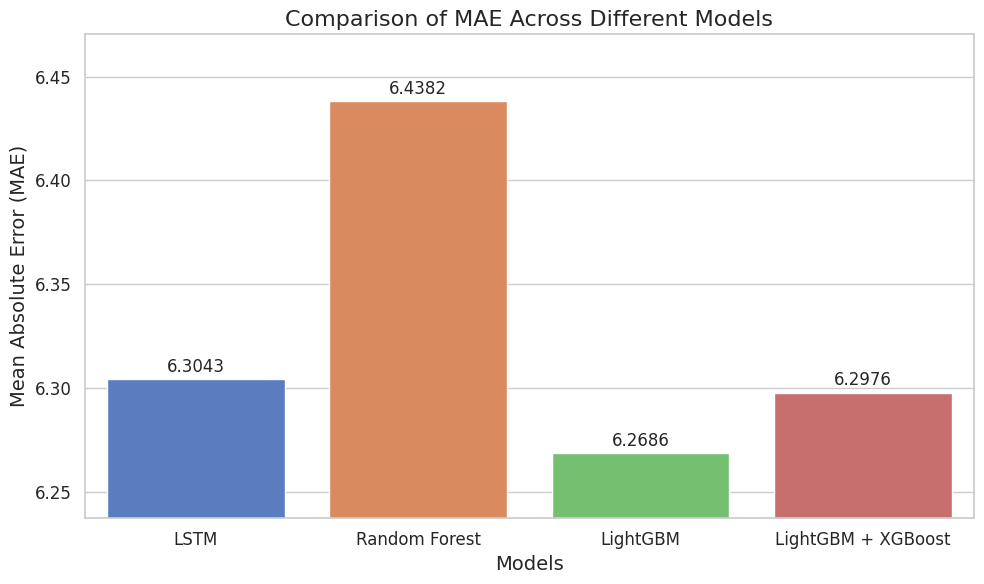

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for plotting
models = ['LSTM','Random Forest', 'LightGBM','LightGBM + XGBoost' ]
mae_values = [6.3043,6.4382, 6.2686,6.2976]

# Calculate the minimum MAE for setting y-axis limits
min_mae = min(mae_values)

# Styling
sns.set(style="whitegrid")

# Creating the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=models, y=mae_values, palette="muted")

# Annotations
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.4f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

# Adjusting y-axis to zoom in on differences
plt.ylim(min_mae * 0.995, max(mae_values) * 1.005)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.title('Comparison of MAE Across Different Models', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display plot
plt.show()


# 07 Model Optimization - LightGBM & LSTM

# First Step : LightGBM - Find the best parameters

### Changing boosting type (gbdt to goss)

In [17]:
X = merged_df[x_cols]
y = merged_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params2 = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "goss",
      'learning_rate': 0.02,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.9,
  }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(lgb_params2, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=False)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.489689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 4185624, number of used features: 25
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -0.046514
MAE: 5.997035118995316


### Adding Entire Dataset (4190208 Data Points)

In [112]:
X = merged_df[x_cols]
y = merged_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params_more = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'learning_rate': 0.02,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
  }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model_more = lgb.train(lgb_params_more, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=False)

y_pred = lgb_model_more.predict(X_test, num_iteration=lgb_model_more.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.066862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 4185624, number of used features: 25
[LightGBM] [Info] Start training from score -0.046514
MAE: 5.985465952998072


### Adjusting Feature_Fraction (90% - 20%)

In [114]:
X = merged_df[x_cols]
y = merged_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params2 = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'learning_rate': 0.02,
      'lambda_l1': 1,
      'lambda_l2': 1,
      'feature_fraction': 0.2,
      'bagging_fraction': 0.9,
  }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(lgb_params2, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=False)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.755608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 4185624, number of used features: 25
[LightGBM] [Info] Start training from score -0.046514
MAE: 6.106821300974915


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] 

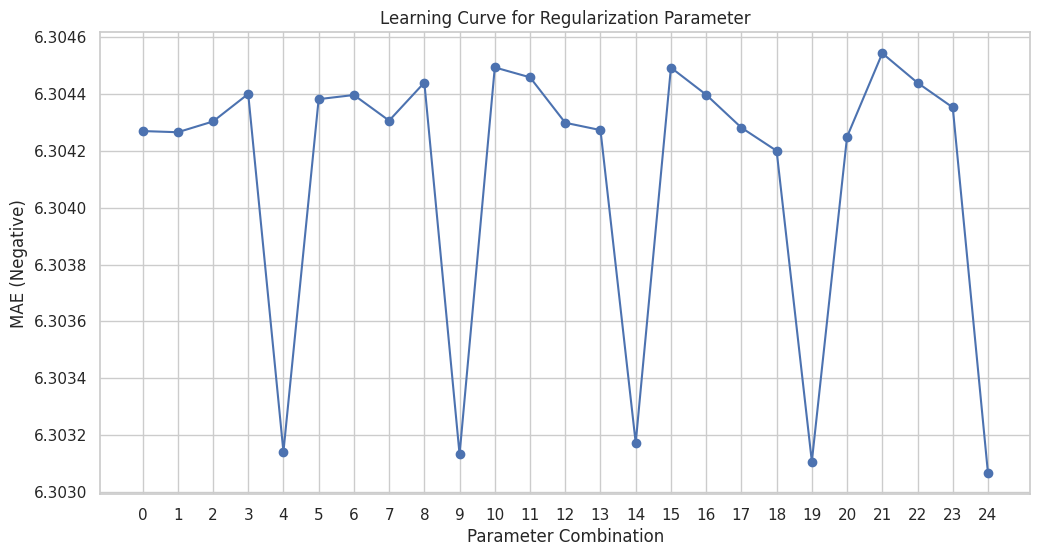

In [113]:
from sklearn.model_selection import cross_val_score

lambda_l1_values = [0, 0.01, 0.1, 1, 10]
lambda_l2_values = [0, 0.01, 0.1, 1, 10]

train_errors = []
valid_errors = []

for lambda_l1 in lambda_l1_values:
    for lambda_l2 in lambda_l2_values:

        lgb_params = {
            "num_leaves": 900,
            "objective": "regression", 
            "metric": "mae", 
            "boosting_type": "gbdt",
            'learning_rate': 0.02,
            'lambda_l1': lambda_l1,
            'lambda_l2': lambda_l2,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.9,
        }
        
        scores = cross_val_score(lgb.LGBMRegressor(**lgb_params), X, y, scoring='neg_mean_absolute_error', cv=5)
        train_error = -scores.mean()  # 注意：交叉验证返回的是负的MAE
        
    
        train_errors.append(train_error)

plt.figure(figsize=(12, 6))
plt.plot(range(len(train_errors)), train_errors, marker='o')
plt.xticks(range(len(train_errors)), range(len(train_errors)))
plt.xlabel('Parameter Combination')
plt.ylabel('MAE (Negative)')
plt.title('Learning Curve for Regularization Parameter')
plt.grid(True)
plt.show()

Based on the provided learning curve, the conclusion is that the parameter combination corresponding to the last data point, with 
λ l1 =10 & λ l2 =10， resulted in the lowest Mean Absolute Error (MAE) value. This suggests that within the tested range, increasing both L1 and L2 regularization to a value of 10 offers the best model performance, minimizing the MAE and potentially providing a good balance against overfitting. 

In [19]:
X = merged_df[x_cols]
y = merged_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params2 = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "goss",
      'learning_rate': 0.05,
      'lambda_l1': 10,
      'lambda_l2': 10,
      'feature_fraction': 0.8,
      'bagging_fraction': 0.9,
  }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(lgb_params2, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=False)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.420287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 4185624, number of used features: 25
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -0.046514
MAE: 5.882758389314665


In [20]:
X = merged_df[x_cols]
y = merged_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params2 = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'learning_rate': 0.05,
      'lambda_l1': 10,
      'lambda_l2': 10,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
  }

lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

lgb_model = lgb.train(lgb_params2, lgb_train, num_boost_round=2000, valid_sets=[lgb_train, lgb_test], early_stopping_rounds=100, verbose_eval=False)

y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.161625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 4185624, number of used features: 25
[LightGBM] [Info] Start training from score -0.046514
MAE: 5.825399629238949


In [ ]:
# Function to calculate MAE
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Custom evaluation function for LightGBM
def feval_MAE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'MAE', round(mae(y_true=labels, y_pred=preds), 5), False

# LightGBM parameters
params = {
      "num_leaves": 900,
      "objective": "regression", 
      "metric": "mae", 
      "boosting_type": "gbdt",
      'learning_rate': 0.05,
      'lambda_l1': 10,
      'lambda_l2': 10,
      'feature_fraction': 0.9,
      'bagging_fraction': 0.9,
  }

# K-Fold Cross-Validation setup
kf = KFold(n_splits=2, shuffle=True, random_state=42)
models = []
mae_scores = []
train_results = [] # Initialize list for training results
valid_results = [] # Initialize list for validation results

# Performing K-Fold Cross-Validation
for fold, (idx_1, idx_2) in enumerate(kf.split(X)):
    print("Fold :", fold + 1)

    train_data = lgb.Dataset(X.iloc[idx_1], label=y.iloc[idx_1])
    valid_data = lgb.Dataset(X.iloc[idx_2], label=y.iloc[idx_2])

    # Capture evaluation results
    evals_result = {}

    model = lgb.train(
        params=params,
        train_set=train_data,
        valid_sets=[train_data, valid_data],
        num_boost_round=20000,
        callbacks=[lgb.early_stopping(1000), lgb.log_evaluation(2000)],
        feval=feval_MAE,
        evals_result=evals_result
    )

    # Store the model and results
    models.append(model)
    train_results.append(evals_result['training']['l1'])
    valid_results.append(evals_result['valid_1']['l1'])

    # Predict on the validation set
    preds = model.predict(X.iloc[idx_2], num_iteration=model.best_iteration)
    mae_score = mean_absolute_error(y.iloc[idx_2], preds)
    mae_scores.append(mae_score)
    print(f"Fold {fold + 1} | MAE: {mae_score}")

# Calculate and print the average MAE across all folds
average_mae = np.mean(mae_scores)
print(f"\nAverage MAE across all folds: {average_mae}")

Fold : 1


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.412667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5613
[LightGBM] [Info] Number of data points in the train set: 2616015, number of used features: 24
[LightGBM] [Info] Start training from score -0.036895
Training until validation scores don't improve for 1000 rounds
[2000]	training's l1: 4.72618	training's MAE: 4.72618	valid_1's l1: 5.91917	valid_1's MAE: 5.91917
[4000]	training's l1: 3.86497	training's MAE: 3.86497	valid_1's l1: 5.8025	valid_1's MAE: 5.8025
[6000]	training's l1: 3.23546	training's MAE: 3.23546	valid_1's l1: 5.73321	valid_1's MAE: 5.73321
[8000]	training's l1: 2.74809	training's MAE: 2.74809	valid_1's l1: 5.68159	valid_1's MAE: 5.68159
[10000]	training's l1: 2.35202	training's MAE: 2.35202	valid_1's l1: 5.64612	valid_1's MAE: 5.64612
[12000]	training's l1: 2.02528	training's MAE: 2.02528	valid_1's l1: 5.61999	valid_1's MAE: 5.6

# Second Step : LightGBM - Try sliding window processed dataset

In [28]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


### TEST 1

In [30]:
def dataloader_to_df(dataloader, window_size):
    data_list = []
    target_list = []
    for data, target in dataloader:
        # Reshape data to 2D by combining the first two dimensions
        reshaped_data = data.view(-1, data.shape[-1])
        data_list.append(reshaped_data.numpy())

        # Repeat each target value 'window_size' times to match the reshaped data
        repeated_target = np.repeat(target.numpy(), window_size)
        target_list.append(repeated_target)
    
    data_array = np.concatenate(data_list, axis=0)
    target_array = np.concatenate(target_list, axis=0)

    # Truncate arrays to match lengths
    min_length = min(len(data_array), len(target_array))
    data_array = data_array[:min_length]
    target_array = target_array[:min_length]

    df = pd.DataFrame(data_array)
    df['target'] = target_array
    return df

# Convert DataLoader to DataFrame
train_df = dataloader_to_df(train_loader, window_size)
test_df = dataloader_to_df(test_loader, window_size)

In [31]:
# Separate features and target
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [32]:
# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test= lgb.Dataset(X_test, label=y_test, reference=lgb_train)


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated an

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.774045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6116
[LightGBM] [Info] Number of data points in the train set: 20928100, number of used features: 27
[LightGBM] [Info] Start training from score -0.014765


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


MAE: 0.6461613850379282


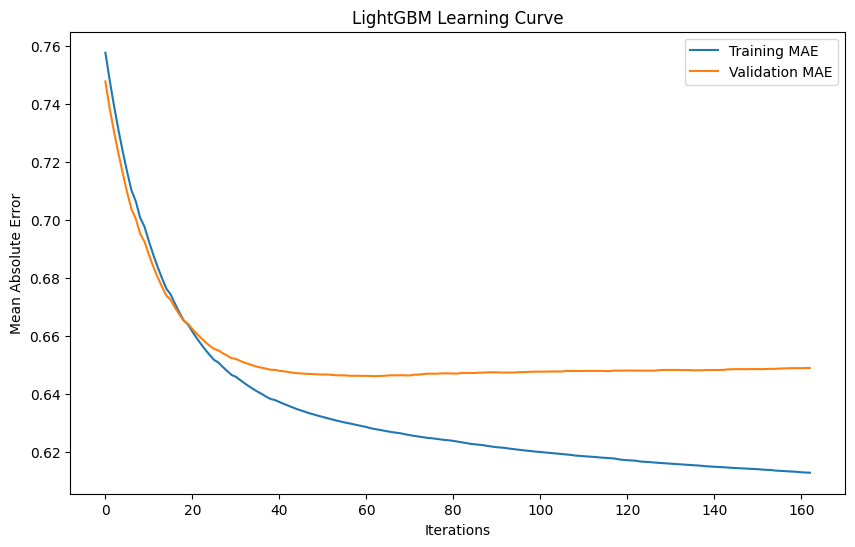

In [28]:


# Define LightGBM parameters
lgb_params2 = {
    "num_leaves": 900,
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    'learning_rate': 0.05,
    'lambda_l1': 10,
    'lambda_l2': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9
}

# Train the model with a callback to record evaluation results
evals_result = {}  # Store evaluation results
lgb_model = lgb.train(
    lgb_params2, 
    lgb_train, 
    num_boost_round=2000, 
    valid_sets=[lgb_train, lgb_test], 
    early_stopping_rounds=100, 
    verbose_eval=False, 
    evals_result=evals_result
)

# Predict on test data
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['training']['l1'], label='Training MAE')
plt.plot(evals_result['valid_1']['l1'], label='Validation MAE')
plt.title('LightGBM Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


# LSTM

# First Step : LSTM- Find the best parameters

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import StepLR


In [20]:
X = merged_df[x_cols]
y = merged_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
  
    X_train = np.nan_to_num(X_train)

if np.any(np.isnan(X_test)) or np.any(np.isinf(X_test)):
    X_test = np.nan_to_num(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2):  # LSTM层数设置为2
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions.squeeze()

input_size = 25
hidden_layer_size = 50 
output_size = 1
num_layers = 2
model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01) 

scheduler = StepLR(optimizer, step_size=5, gamma=0.1) 

best_loss = np.inf
patience = 3  
patience_counter = 0

epochs = 5  
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for sequence, target in train_loader:
        sequence = sequence.unsqueeze(1)
        optimizer.zero_grad()
        prediction = model(sequence)
        loss = loss_function(prediction.squeeze(), target.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step() 
    avg_loss = total_loss / len(train_loader)

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')

model.eval()
total_mae = 0.0
total_samples = 0
with torch.no_grad():
    for sequence, target in test_loader:
        sequence = sequence.unsqueeze(1)
        prediction = model(sequence)
        mae_loss = loss_function(prediction.squeeze(), target.view(-1))
        total_mae += mae_loss.item() * len(target)
        total_samples += len(target)

average_mae = total_mae / total_samples
print(f'Average MAE: {average_mae}')


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/5, Loss: 6.3270
Epoch 2/5, Loss: 6.3206
Epoch 3/5, Loss: 6.3205
Epoch 4/5, Loss: 6.3213
Epoch 5/5, Loss: 6.3249
Average MAE: 6.317466217370812


# Second Step : LSTM - Adding Sliding Window Data

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

TEST 1

Epoch 1, Training Loss: 0.6504099674534155, Testing Loss: 0.6757768325516299
Epoch 2, Training Loss: 0.6485929940898321, Testing Loss: 0.7716427351704147
Epoch 3, Training Loss: 0.6814059751994798, Testing Loss: 0.7985430316401836
Epoch 4, Training Loss: 0.6898814356123274, Testing Loss: 0.7249792403007864
Epoch 5, Training Loss: 0.7022096418996384, Testing Loss: 0.7240114338291828
Epoch 6, Training Loss: 0.694617492030291, Testing Loss: 0.7249330853496908
Epoch 7, Training Loss: 0.7058043978916148, Testing Loss: 0.7245574951970201
Epoch 8, Training Loss: 0.7035833355880383, Testing Loss: 0.7242088121670801
Epoch 9, Training Loss: 0.6968896237399685, Testing Loss: 0.7303261540392241
Epoch 10, Training Loss: 0.6989651518149173, Testing Loss: 0.7929347178438929


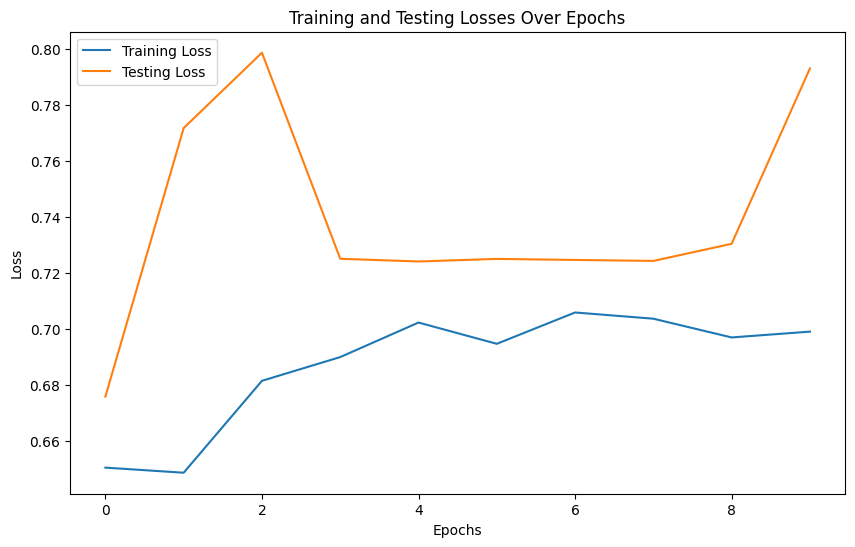

Average MAE on Test Data: 0.7929694204866627


NameError: name 'test_targets' is not defined

<Figure size 1200x600 with 0 Axes>

In [25]:
# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only use the output of the last time step
        return predictions

# Model Instantiation
input_size = 27  # Number of features
hidden_layer_size = 50
output_size = 1
num_layers = 3
model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers)

# Loss Function and Optimizer
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model
num_epochs = 10  # Adjust as needed
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for sequences, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(sequences)
        loss = loss_function(predictions, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for sequences, targets in test_loader:
            predictions = model(sequences)
            loss = loss_function(predictions, targets.unsqueeze(1))
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Testing Loss: {avg_test_loss}')

# Plotting Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation
model.eval()
total_mae = 0.0
with torch.no_grad():
    for sequences, targets in test_loader:
        predictions = model(sequences)
        mae_loss = loss_function(predictions, targets.unsqueeze(1))
        total_mae += mae_loss.item() * sequences.size(0)

average_mae = total_mae / len(test_dataset)
print(f'Average MAE on Test Data: {average_mae}')


# Plot a segment of the test data
segment_size = 200  # Adjust as needed
start_index = 0  # Adjust as needed
plt.figure(figsize=(12, 6))
plt.plot(test_targets[start_index:start_index + segment_size], label='Actual')
plt.plot(test_predictions[start_index:start_index + segment_size], label='Predicted')
plt.title('LSTM Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


TEST 2

Epoch 1, Training Loss: 0.6600034267500441, Testing Loss: 0.6792086571305543
Epoch 2, Training Loss: 0.6756093947184999, Testing Loss: 0.6806477982967565


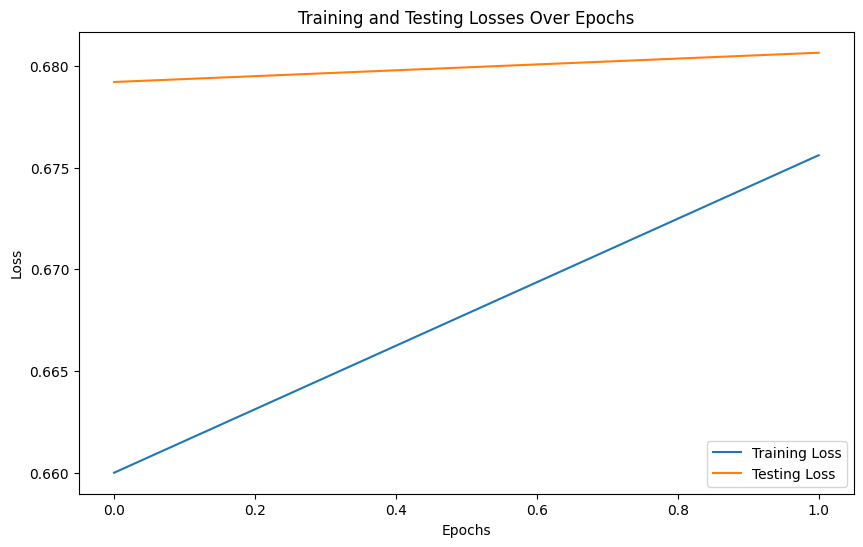

Average MAE on Test Data: 0.680675685820951


In [24]:
# LSTM Model Definition with Dropout
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=1, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        # Add dropout to LSTM
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])  # Only use the output of the last time step
        return predictions

# Model Instantiation with Dropout
input_size = 27  # Number of features
hidden_layer_size = 50
output_size = 1
num_layers = 3
dropout_rate = 0.5  # Dropout rate
model = LSTMModel(input_size, hidden_layer_size, output_size, num_layers, dropout_rate)

# Loss Function and Optimizer
loss_function = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the Model with Early Stopping
num_epochs = 2  
train_losses, test_losses = [], []
early_stopping_patience = 2
early_stopping_counter = 0
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for sequences, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(sequences)
        loss = loss_function(predictions, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for sequences, targets in test_loader:
            predictions = model(sequences)
            loss = loss_function(predictions, targets.unsqueeze(1))
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    # Implementing Early Stopping
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}.')
            break

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Testing Loss: {avg_test_loss}')

# Plotting Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation
model.eval()
total_mae = 0.0
with torch.no_grad():
    for sequences, targets in test_loader:
        predictions = model(sequences)
        mae_loss = loss_function(predictions, targets.unsqueeze(1))
        total_mae += mae_loss.item() * sequences.size(0)

average_mae = total_mae / len(test_dataset)
print(f'Average MAE on Test Data: {average_mae}')



# 08 Model Evaluation

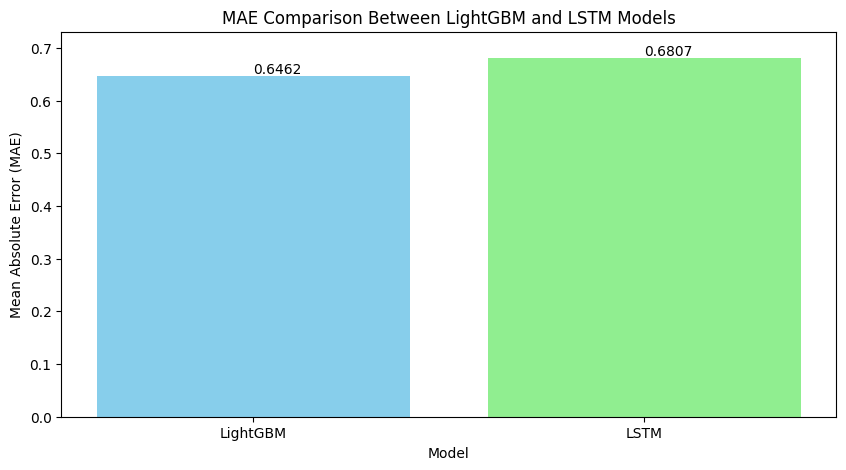

In [40]:
# Plotting the MAE comparison as a bar chart

# MAE results from previous output
mae_lightgbm = 0.6462
mae_lstm = 0.6807

# Names of models
models = ['LightGBM', 'LSTM']

# MAE values
mae_values = [mae_lightgbm, mae_lstm]

# Creating the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(models, mae_values, color=['skyblue', 'lightgreen'])

# Adding the text on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Comparison Between LightGBM and LSTM Models')
plt.ylim(0, max(mae_values) + 0.05)  # Set y-axis limit to make text readable
plt.show()


# 08 Conclusions 

The conclusion that can be drawn from this project stresses the importance of understanding the nature of the data and the role of preprocessing in modeling. While model selection is crucial, the way the data is presented to these models can often be the defining factor in their predictive performance. In this context, the careful preparation of the dataset, using methods such as the sliding window, appears to be a pivotal step that can bridge the performance gap between different types of models, such as tree-based algorithms and neural networks.

Ultimately, the key takeaway is that the structural integrity and relevance of features within the data can be as decisive as the sophistication of the modeling technique applied. The interplay between data preparation and model optimization is a delicate balance that must be managed to maximize the predictive prowess of machine learning models in time-series analysis.